<a href="https://colab.research.google.com/github/Dh0t/NLP/blob/main/UAS_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#!pip install numpy pandas scikit-learn matplotlib tensorflow

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [21]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/smartphone_cleaned_v5.csv")

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Fitur yang digunakan
numeric_features = [
    'ram_capacity', 'internal_memory', 'battery_capacity',
    'processor_speed', 'num_cores', 'screen_size',
    'refresh_rate', 'primary_camera_rear', 'primary_camera_front'
]
categorical_features = ['brand_name', 'processor_brand', 'os']
target_column = 'price'

X = df[numeric_features + categorical_features]
y = df[target_column]

In [24]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_processed = preprocessor.fit_transform(X)

In [25]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Reshape untuk RNN
X_train_rnn = X_train.toarray().reshape((X_train.shape[0], 1, X_train.shape[1])) \
    if hasattr(X_train, "toarray") else X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.toarray().reshape((X_test.shape[0], 1, X_test.shape[1])) \
    if hasattr(X_test, "toarray") else X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [26]:
# Bangun model RNN
rnn_model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Model GRU
gru_model = Sequential([
    GRU(64, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [28]:
# Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32,
                            validation_split=0.2, callbacks=[early_stop], verbose=1)

gru_history = gru_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32,
                            validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2121136896.0000 - mae: 31610.1738 - val_loss: 4862921728.0000 - val_mae: 37335.4922
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2678791168.0000 - mae: 33584.8281 - val_loss: 4862862336.0000 - val_mae: 37334.8438
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1694606848.0000 - mae: 29357.1758 - val_loss: 4862785536.0000 - val_mae: 37334.0391
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2031159296.0000 - mae: 29892.7969 - val_loss: 4862684160.0000 - val_mae: 37332.9922
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2568864256.0000 - mae: 33806.1719 - val_loss: 4862549504.0000 - val_mae: 37331.6172
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2246768128.0000 - mae: 31561.5234 - val_loss: 4862382592.0000 - val_mae: 37329.9141
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2268412416.0000 - mae: 32327.4570 - val_loss: 4862171648.0000 - val_mae: 37327.7969
Ep

In [29]:
# Evaluation
rnn_eval = rnn_model.evaluate(X_test_rnn, y_test)
gru_eval = gru_model.evaluate(X_test_rnn, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1878408448.0000 - mae: 30914.3555 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1881847424.0000 - mae: 30929.0527 


In [30]:
print("\nRNN Evaluation - Loss (MSE) & MAE:", rnn_eval)
print("GRU Evaluation - Loss (MSE) & MAE:", gru_eval)


RNN Evaluation - Loss (MSE) & MAE: [1935694976.0, 31489.541015625]
GRU Evaluation - Loss (MSE) & MAE: [1939587584.0, 31507.943359375]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


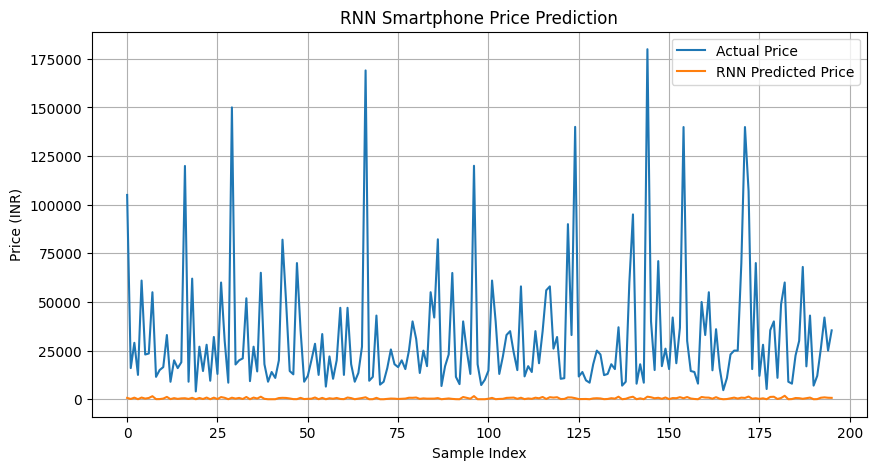

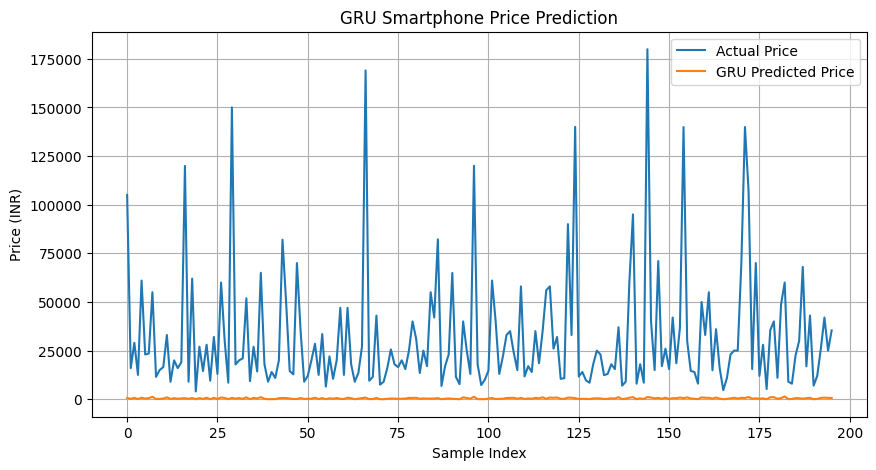

In [32]:
# Make predictions
rnn_predictions = rnn_model.predict(X_test_rnn)
gru_predictions = gru_model.predict(X_test_rnn)

# Flatten predictions for plotting
rnn_predictions_flat = rnn_predictions.flatten()
gru_predictions_flat = gru_predictions.flatten()

# Ensure y_test is a numpy array for consistent plotting
actual_price = y_test.values

# Plot for RNN
plt.figure(figsize=(10, 5))
plt.plot(actual_price, label='Actual Price')
plt.plot(rnn_predictions_flat, label='RNN Predicted Price')
plt.title('RNN Smartphone Price Prediction')
plt.xlabel('Sample Index')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for GRU
plt.figure(figsize=(10, 5))
plt.plot(actual_price, label='Actual Price')
plt.plot(gru_predictions_flat, label='GRU Predicted Price')
plt.title('GRU Smartphone Price Prediction')
plt.xlabel('Sample Index')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

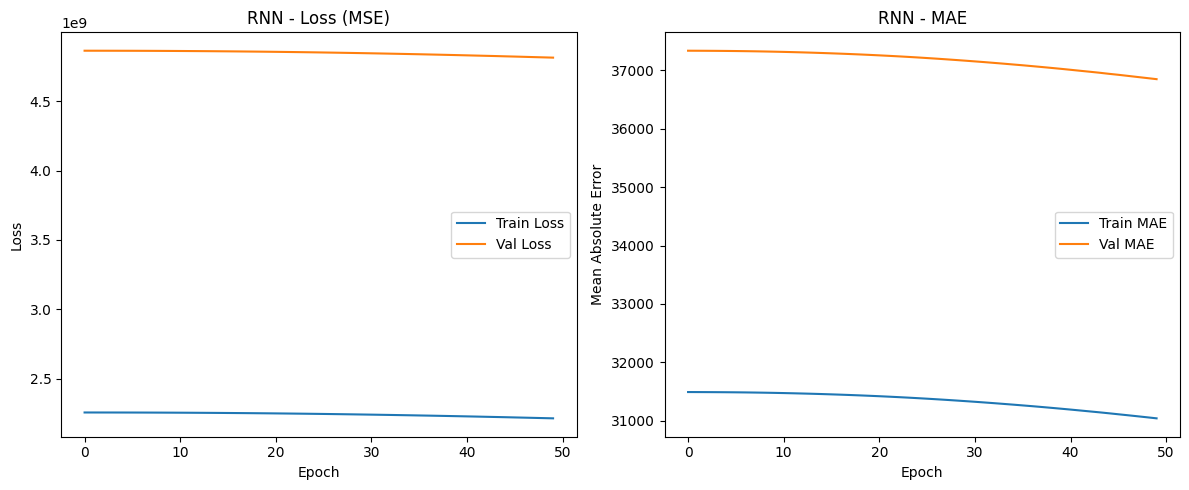

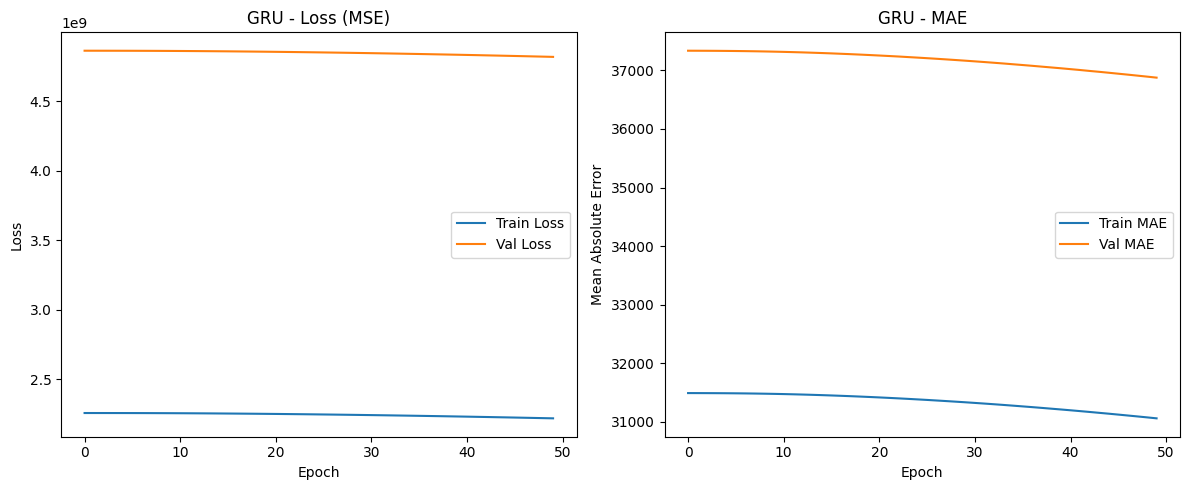

In [33]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot Loss (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'{model_name} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Jalankan untuk kedua model
plot_history(rnn_history, "RNN")
plot_history(gru_history, "GRU")
